## pg_stat_statement 
What is pg_stat_statement 
https://www.postgresql.org/docs/current/pgstatstatements.html 


# Configuration
Check whether the extension exists

In [20]:
import sqlalchemy
import pandas as pd
import configparser
import matplotlib.pyplot as plt 

# Read from the Config file
config = configparser.ConfigParser() 
config.read_file(open(r'../ipynb.cfg'))

con_str = config.get('con_str', 'PG_AIRBASES') 

engine = sqlalchemy.create_engine(con_str)

# print("Connecting with engine " + str(engine))
connection = engine.connect()
query = "select * from pg_settings;"
df = pd.read_sql_query(query, connection)
df

,name,setting,unit,category,short_desc,extra_desc,context,vartype,source,min_val,max_val,enumvals,boot_val,reset_val,sourcefile,sourceline,pending_restart
0,allow_system_table_mods,off,None,Developer Options,Allows modifications of the structure of syste...,None,sighup,bool,default,None,None,None,off,off,None,NaN,False
1,application_name,,None,Reporting and Logging / What to Log,Sets the application name to be reported in st...,None,user,string,default,None,None,None,,,None,NaN,False
2,archive_cleanup_command,,None,Write-Ahead Log / Archive Recovery,Sets the shell command that will be executed a...,None,sighup,string,default,None,None,None,,,None,NaN,False
3,archive_command,/etc/rds/dbbin/pgscripts/rds_wal_archive %p,None,Write-Ahead Log / Archiving,Sets the shell command that will be called to ...,None,sighup,string,configuration file,None,None,None,,/etc/rds/dbbin/pgscripts/rds_wal_archive %p,/rdsdbdata/config/postgresql.conf,1.0,False
4,archive_mode,on,None,Write-Ahead Log / Archiving,Allows archiving of WAL files using archive_co...,None,postmaster,enum,configuration file,None,None,"[always, on, off]",off,on,/rdsdbdata/config/postgresql.conf,110.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,wal_writer_flush_after,128,8kB,Write-Ahead Log / Settings,Amount of WAL written out by WAL writer that t...,None,sighup,integer,default,0,2147483647,None,128,128,None,NaN,False
368,work_mem,4096,kB,Resource Usage / Memory,Sets the maximum memory to be used for query w...,This much memory can be used by each internal ...,user,integer,default,64,2147483647,None,4096,4096,None,NaN,False
369,xmlbinary,base64,None,Client Connection Defaults / Statement Behavior,Sets how binary values are to be encoded in XML.,None,user,enum,default,None,None,"[base64, hex]",base64,base64,None,NaN,False
370,xmloption,content,None,Client Connection Defaults / Statement Behavior,Sets whether XML data in implicit parsing and ...,None,user,enum,default,None,None,"[content, document]",content,content,None,NaN,False


## Connections
Shows: confired max connvection vs actaul active and idle connections
TODO: also show how quickly connections are recycled (=> a Proxy is needed). 

In [21]:
query_ccnnections_metrics = """
SELECT 'configured_max_connection' as metric_name, 
	setting as value, 
  short_desc
 FROM pg_settings 
 WHERE name = 'max_connections'
 
	Union all 
SELECT 
	'active_connections' as metric_name,
  COUNT(*)::text as value,
  'Active connections' as short_desc
FROM pg_stat_activity  
WHERE pid <> pg_backend_pid() 
AND state = 'active'

	Union all 
SELECT 
	'idle_connections' as metric_name,
  COUNT(*)::text as value,
  'Idle connections' as short_desc
FROM pg_stat_activity  
WHERE pid <> pg_backend_pid() 
AND state in ('idle in transaction', 'idle');"""

df = pd.read_sql_query(query_ccnnections_metrics, connection)
df

,metric_name,value,short_desc
0,configured_max_connection,835,Sets the maximum number of concurrent connecti...
1,active_connections,0,Active connections
2,idle_connections,39,Idle connections


Connections Breakdown by DB

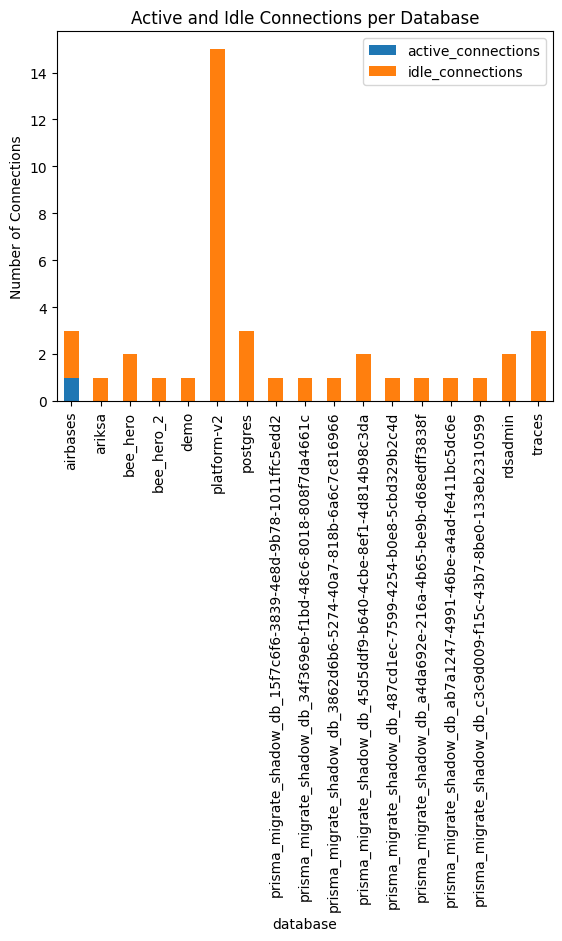

In [27]:
query_ccnnections_metrics = """
SELECT datname as database, 
       COUNT(*) FILTER (WHERE state = 'active') AS active_connections, 
       COUNT(*) FILTER (WHERE state = 'idle') AS idle_connections
FROM pg_stat_activity
WHERE datname IS NOT NULL
GROUP BY datname
ORDER BY datname
"""

df = pd.read_sql_query(query_ccnnections_metrics, connection)
df

# Plot the results as a bar chart
ax = df.plot(kind='bar', x='database', stacked=True)
ax.set_xlabel('database')
ax.set_ylabel('Number of Connections')
ax.set_title('Active and Idle Connections per Database')
plt.show()